In [1]:
from trainer import Trainer
from resnet import lessFilterResNet50FeatureExtract
import pandas as pd
import numpy as np
import torch

In [2]:
train_df = pd.read_json('Data/denoised_processed_train.json')
print(train_df.shape)

(1604, 3)


## Test feature extraction functionality

In [3]:
def get_prediction(df, fold=1, seed=0):
    is_transfer_learning = False
    model = lessFilterResNet50FeatureExtract()
    model_name = 'Trained_model/less_filter_resent50_' + str(fold) + '.db'
    # testing snap shot for essemble
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)
    
    tr = Trainer(
            model,
            optimizer,
            epochs=1800,
            milestones=[300, 1100, 1600],
            gamma=0.2,
            batch_size=128, 
            use_cuda=True, 
            gpu_idx=0,
            best_model_name = model_name,
            seed=seed,
            verbose=0)

    tr.load_checkpoint()

    data_augmentation_args = {
        'mirror': False, # not useful here
        'rotate': True,
        'scale': True,
        'translation': True
    }

    predictions = tr.test(df, is_transfer_learning=is_transfer_learning, is_augment=True, data_augmentation_args=data_augmentation_args)
    
    del model, tr, optimizer
    return predictions

In [7]:
predictions = get_prediction(train_df)
print(predictions.shape)
print(pd.Series(predictions[0] != 0.0).value_counts())
predictions

gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x0000020C588A3E80>, <torchvision.transforms.transforms.Lambda object at 0x0000020C588A3FD0>, <torchvision.transforms.transforms.ToTensor object at 0x0000020C588A3940>]
(1604, 18433)
False    17622
True       811
dtype: int64


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.18467656],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.12919928],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.19141054],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.14403118],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.17061992],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.10167369]], dtype=float32)

## Test augmentation's effect on the network output (features response before avg. pooling layer)

In [28]:
predictions = [get_prediction(train_df, seed=i) for i in range(10)]

gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x0000020C2F4774E0>, <torchvision.transforms.transforms.Lambda object at 0x0000020C2F3B4278>, <torchvision.transforms.transforms.ToTensor object at 0x0000020C53D52860>]
gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x0000020C53D52080>, <torchvision.transforms.transforms.Lambda object at 0x0000020C2B55FE48>, <torchvision.transforms.transforms.ToTensor object at 0x0000020C2B55F400>]
gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x0000020C2F47E860>, <torchvision.transforms.transforms.Lambda object at 0x0000020C2F47E278>, <torchvision.transforms.transforms.ToTensor object at 0x0000020C2F47EA20>]
gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x0000020C2F47E278>, <torchvision.transforms.transforms.Lambda object at 0x0000020C2F47E4A8>, <torchvision.transforms.transforms.ToTensor

In [29]:
print(np.array(predictions).shape)

(10, 1604, 18433)


In [30]:
predictions = np.array(predictions)
avg_predictions = predictions.mean(axis=0)
std_predictions = predictions.std(axis=0)

print(avg_predictions)
print(std_predictions)

[[ 0.          0.          0.         ...,  0.          0.         -0.18467654]
 [ 0.          0.          0.         ...,  0.          0.         -0.12919928]
 [ 0.          0.          0.         ...,  0.          0.         -0.19141054]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.         -0.14403118]
 [ 0.          0.          0.         ...,  0.          0.         -0.17061993]
 [ 0.          0.          0.         ...,  0.          0.         -0.10167368]]
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   1.49011612e-08]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,

In [35]:
def check_dev(index):
    large_dev_count = 0
    for i in range(1604):
        large_dev_count += pd.Series(std_predictions[index] > 1e-3).value_counts()

    print(large_dev_count)
    

In [36]:
print('total_count=', 1604*18433)
for i in range(30):
    check_dev(i)

total_count= 29566532
False    28195112
True      1371420
dtype: int64
False    28243232
True      1323300
dtype: int64
False    28291352
True      1275180
dtype: int64
False    28164636
True      1401896
dtype: int64
False    28283332
True      1283200
dtype: int64
False    29013152
True       553380
dtype: int64
False    28196716
True      1369816
dtype: int64
False    28884832
True       681700
dtype: int64
False    28357116
True      1209416
dtype: int64
False    28926536
True       639996
dtype: int64
False    28252856
True      1313676
dtype: int64
False    28143784
True      1422748
dtype: int64
False    28223984
True      1342548
dtype: int64
False    28398820
True      1167712
dtype: int64
False    28235212
True      1331320
dtype: int64
False    29027588
True       538944
dtype: int64
False    28835108
True       731424
dtype: int64
False    29019568
True       546964
dtype: int64
False    28278520
True      1288012
dtype: int64
False    28872000
True       694532
dtype: int6

### Seems that the network output is affected by the data augmentation, we'll average the feature response with data augmentation

In [4]:
import gc

In [5]:
n_models = 5
repeat_count = 40

for nm in range(n_models):
    prediction = get_prediction(train_df, fold=nm+1, seed=0)
    for i in range(repeat_count-1):
        next_prediction = get_prediction(train_df, fold=nm+1, seed=i+1)
        prediction += next_prediction
        del next_prediction
        gc.collect()
        
    prediction = np.array(prediction, dtype=np.float32) / (repeat_count*1.0)
    
    print(prediction.shape)
    columns = ['f_{}_{}'.format(nm+1, i) for i in range(prediction.shape[1])]
    df = pd.DataFrame(data=prediction,    # values
              columns=columns)  # 1st row as the column names
    print(df.head(3))
    df.to_csv('Data/resnet_extract_features_fold_{}_{}_avg_train.csv'.format(nm+1, repeat_count), float_format="%.6f", index=False)
    
    del df, prediction, columns
    gc.collect()

gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x000001ED2B5DD128>, <torchvision.transforms.transforms.Lambda object at 0x000001ED2B5DD1D0>, <torchvision.transforms.transforms.ToTensor object at 0x000001ED2B5DD240>]
gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x000001ED04349160>, <torchvision.transforms.transforms.Lambda object at 0x000001ED04321B38>, <torchvision.transforms.transforms.ToTensor object at 0x000001ED04321CC0>]
gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x000001ED78AC2748>, <torchvision.transforms.transforms.Lambda object at 0x000001ED78AC2240>, <torchvision.transforms.transforms.ToTensor object at 0x000001ED78AC2668>]
gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x000001ED2B5DD6D8>, <torchvision.transforms.transforms.Lambda object at 0x000001ED2B5DD780>, <torchvision.transforms.transforms.ToTensor

gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x000001ED2B5DDCC0>, <torchvision.transforms.transforms.Lambda object at 0x000001ED2B5DDC88>, <torchvision.transforms.transforms.ToTensor object at 0x000001ED2B5DD198>]
gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x000001ED26C4D7F0>, <torchvision.transforms.transforms.Lambda object at 0x000001ED1F6F5C50>, <torchvision.transforms.transforms.ToTensor object at 0x000001ED26E64940>]
gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x000001ED78AC2F98>, <torchvision.transforms.transforms.Lambda object at 0x000001ED78AC2EB8>, <torchvision.transforms.transforms.ToTensor object at 0x000001ED78AC2A20>]
gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x000001ED2B5F42B0>, <torchvision.transforms.transforms.Lambda object at 0x000001ED2B5F4240>, <torchvision.transforms.transforms.ToTensor

gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x000001ED2B5DDC88>, <torchvision.transforms.transforms.Lambda object at 0x000001ED2B5DD978>, <torchvision.transforms.transforms.ToTensor object at 0x000001ED2B5DDF28>]
gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x000001ED7897E320>, <torchvision.transforms.transforms.Lambda object at 0x000001ED7897E358>, <torchvision.transforms.transforms.ToTensor object at 0x000001ED2B5F9E80>]
gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x000001ED2B5F4400>, <torchvision.transforms.transforms.Lambda object at 0x000001ED2B5F43C8>, <torchvision.transforms.transforms.ToTensor object at 0x000001ED2B5F42B0>]
gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x000001ED26EBDA58>, <torchvision.transforms.transforms.Lambda object at 0x000001ED26EBDFD0>, <torchvision.transforms.transforms.ToTensor

gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x000001ED2B5F4F98>, <torchvision.transforms.transforms.Lambda object at 0x000001ED2B5F4358>, <torchvision.transforms.transforms.ToTensor object at 0x000001ED2B5F48D0>]
gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x000001ED1F6F5EF0>, <torchvision.transforms.transforms.Lambda object at 0x000001ED26EBD828>, <torchvision.transforms.transforms.ToTensor object at 0x000001ED26EBD668>]
gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x000001ED1E752DA0>, <torchvision.transforms.transforms.Lambda object at 0x000001ED26C4D7F0>, <torchvision.transforms.transforms.ToTensor object at 0x000001ED2B5DD080>]
gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x000001ED26C4D0F0>, <torchvision.transforms.transforms.Lambda object at 0x000001ED2B5DDD30>, <torchvision.transforms.transforms.ToTensor

gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x000001ED2B5DDCF8>, <torchvision.transforms.transforms.Lambda object at 0x000001ED2B5DD390>, <torchvision.transforms.transforms.ToTensor object at 0x000001ED2B5DD828>]
gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x000001ED2B5DD278>, <torchvision.transforms.transforms.Lambda object at 0x000001ED2B5DD0B8>, <torchvision.transforms.transforms.ToTensor object at 0x000001ED2B5DDD68>]
gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x000001ED223A94A8>, <torchvision.transforms.transforms.Lambda object at 0x000001ED2B5DD588>, <torchvision.transforms.transforms.ToTensor object at 0x000001ED2B5DDFD0>]
gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x000001ED1E575748>, <torchvision.transforms.transforms.Lambda object at 0x000001ED26E64940>, <torchvision.transforms.transforms.ToTensor

gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x000001ED78AC20F0>, <torchvision.transforms.transforms.Lambda object at 0x000001ED78AC2860>, <torchvision.transforms.transforms.ToTensor object at 0x000001ED78AC27B8>]
gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x000001ED78AC2B38>, <torchvision.transforms.transforms.Lambda object at 0x000001ED78AC2F60>, <torchvision.transforms.transforms.ToTensor object at 0x000001ED78AC22B0>]
gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x000001ED1E575748>, <torchvision.transforms.transforms.Lambda object at 0x000001ED1F6F51D0>, <torchvision.transforms.transforms.ToTensor object at 0x000001ED1F6F5C50>]
gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x000001ED2B5F4AC8>, <torchvision.transforms.transforms.Lambda object at 0x000001ED2B5F48D0>, <torchvision.transforms.transforms.ToTensor

gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x000001ED7897E320>, <torchvision.transforms.transforms.Lambda object at 0x000001ED7897E0F0>, <torchvision.transforms.transforms.ToTensor object at 0x000001ED7897E358>]
gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x000001ED2B5F4550>, <torchvision.transforms.transforms.Lambda object at 0x000001ED2B5F4E10>, <torchvision.transforms.transforms.ToTensor object at 0x000001ED2B5F4EF0>]
gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x000001ED1F6FD358>, <torchvision.transforms.transforms.Lambda object at 0x000001ED1F6FD7F0>, <torchvision.transforms.transforms.ToTensor object at 0x000001ED2B5F96D8>]
gpu: 0  available: True
Using:
 [<torchvision.transforms.transforms.ToPILImage object at 0x000001ED26EBD0F0>, <torchvision.transforms.transforms.Lambda object at 0x000001ED26EBD198>, <torchvision.transforms.transforms.ToTensor

In [2]:
all_df = pd.concat([pd.read_csv('Data/resnet_extract_features_fold_{}_40_avg_train.csv'.format(i+1)) for i in range(5)], axis=1)

In [3]:
print(all_df.shape)

(1604, 92165)


In [11]:
import matplotlib.pyplot as plt
from sklearn import decomposition
%matplotlib notebook

In [6]:
pca = decomposition.PCA(whiten=True)

In [7]:
pca.fit(all_df)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

<IPython.core.display.Javascript object>


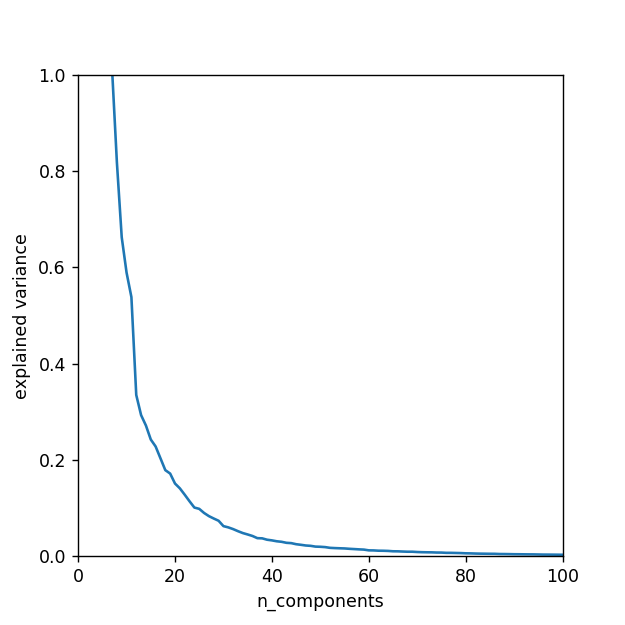

Evaluated components:  92165
Explained variances:  [  2.29538335e+02   1.83189510e+01   4.04709220e+00 ...,   1.04882427e-08
   1.01368143e-08   4.52613145e-29]
False    1461
True      143
dtype: int64


In [52]:
fig = plt.figure(1,figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('n_components')
ax.set_ylabel('explained variance')
ax.set_ylim(0,1.0)
ax.set_xlim(0,100)
ax.plot(pca.explained_variance_)
print("Evaluated components: ", pca.n_components_ )
print("Explained variances: ", pca.explained_variance_)
print(pd.Series(pca.explained_variance_ >= 1e-3).value_counts())

### according to our threshold for explained variances, we kept only 143 features in the end (from 92165->143)

In [53]:
pca = decomposition.PCA(whiten=True, n_components=143)

In [54]:
pca.fit(all_df)

PCA(copy=True, iterated_power='auto', n_components=143, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

### Save the pca into binary for future use

In [55]:
import pickle

In [57]:
with open('pca.pickle', 'wb') as f:
    pickle.dump(pca, f, pickle.HIGHEST_PROTOCOL)

In [56]:
# How to load
'''
import pickle

with open('data.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    data = pickle.load(f)
'''

"\nimport pickle\n\nwith open('data.pickle', 'rb') as f:\n    # The protocol version used is detected automatically, so we do not\n    # have to specify it.\n    data = pickle.load(f)\n"

In [61]:
new_data = np.array(pca.transform(all_df))
print(new_data.shape)
print(new_data)

(1604, 143)
[[ -1.07930593e+00   3.61811937e-01  -1.93310938e-01 ...,   1.61987243e-01
    8.24893281e-02   8.60207560e-01]
 [ -1.27513124e+00   1.09285516e+00  -1.76740196e+00 ...,   1.13151393e+00
   -4.96053238e-01   2.57424762e-01]
 [  1.51560974e-01  -1.42116007e+00  -7.14913200e-01 ...,  -2.71009651e-01
   -2.35507495e-01   5.26263103e-01]
 ..., 
 [ -9.57784791e-01   3.44685590e-02  -3.91137321e-03 ...,  -1.20089888e+00
   -1.18921486e+00  -1.60103576e+00]
 [ -9.57813819e-01   2.71765516e-01   3.44904777e+00 ...,  -7.78936505e-01
    1.05206471e+00   1.04258188e+00]
 [  1.25145321e+00   8.08568233e-01  -3.49437291e-02 ...,  -2.48148603e-03
   -2.27018605e-01  -6.68810969e-01]]


#### Save the new transformed data into training data

In [62]:
columns = ['f_{}'.format(i) for i in range(new_data.shape[1])]
df = pd.DataFrame(data=new_data,    # values
              columns=columns)  # 1st row as the column names
old_train = pd.read_json('Data/train.json')
df['is_iceberg'] = old_train['is_iceberg']
print(df.head(5))
df.to_csv('Data/pca_projected_143_from_resnet_train.csv', float_format="%.6f", index=False)

        f_0       f_1       f_2       f_3       f_4       f_5       f_6  \
0 -1.079306  0.361812 -0.193311 -0.334287  1.333680  0.191776 -0.014934   
1 -1.275131  1.092855 -1.767402 -1.288512  0.030449  0.210168  0.076340   
2  0.151561 -1.421160 -0.714913  0.510925 -0.355384  0.449164 -0.792646   
3 -1.224287  0.939124  2.392260 -0.464758 -0.621168  1.027984 -0.101303   
4 -0.193139 -1.781757  0.492136  0.837812  0.778158  0.949492  0.388729   

        f_7       f_8       f_9     ...         f_134     f_135     f_136  \
0 -0.761672 -0.615338  0.077872     ...      0.259044 -0.628371 -0.552066   
1 -0.432053  1.077584 -0.837257     ...      1.024538 -1.077335 -0.202930   
2 -0.177485  2.652131  2.433116     ...      1.138539  0.368692 -0.138988   
3  0.999282 -0.426461 -0.372872     ...      0.538603  0.337439  0.027309   
4 -0.025536  0.939708 -2.627514     ...     -0.427708  0.703106  0.710379   

      f_137     f_138     f_139     f_140     f_141     f_142  is_iceberg  
0  0.63662